# Automating Contract Review With Transformer Models

##### Task 1: Import the Libraries

In [1]:
import os
import json 
import torch
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import statistics

##### Task 2: Generate Dataset Files

In [2]:
def convert_json_to_csv(json_dir, filename, count):
    with open(json_dir, 'r') as f:
        data = json.load(f)

    # Extract the relevant data and create a DataFrame
    text_list, hypothesis_list, labels_list = [], [], []

    counter = 0  # Counter variable to track the number of appended elements

    for doc in data['documents']:
        annotation_sets = doc.get('annotation_sets', [])
        for annotation_set in annotation_sets:
            annotations = annotation_set.get('annotations', [])
            for annotation in annotations:
                if counter >= count:
                    break  # Break the loop after appending 50 elements

                if isinstance(annotations[annotation], dict):
                    if 'choice' in annotations[annotation]:
                        labels_list.append(annotations[annotation]['choice'])
                        text_list.append(doc['text'])
                        hypothesis_list.append(data['labels'][annotation]['hypothesis'])
                        counter += 1  # Increment the counter

    if len(text_list) == len(hypothesis_list) and len(hypothesis_list) == len(labels_list):
        df = pd.DataFrame({'text': text_list, 'hypothesis': hypothesis_list, 'labels': labels_list})
        # Save the DataFrame to a CSV file
        df.to_csv(filename, index=False)

In [3]:
# Call convert_json_to_csv() function for training, validation and testing.
convert_json_to_csv('/usercode/Contract-nli Dataset/train.json', '/usercode/Contract-nli Dataset/train.csv', 35)
convert_json_to_csv('/usercode/Contract-nli Dataset/valid.json', '/usercode/Contract-nli Dataset/valid.csv', 10)
convert_json_to_csv('/usercode/Contract-nli Dataset/test.json', '/usercode/Contract-nli Dataset/test.csv', 5)

##### Task 3: Calculate Dataset Statistics

In [4]:
# 1. Load the dataset
train_df = pd.read_csv('/usercode/Contract-nli Dataset/train.csv')
valid_df = pd.read_csv('/usercode/Contract-nli Dataset/valid.csv')
test_df = pd.read_csv('/usercode/Contract-nli Dataset/test.csv')



In [5]:
# 2. Display the first and last 5 rows of the training dataset
display(train_df.head(5))
display(train_df.tail(5))


,text,hypothesis,labels
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned


,text,hypothesis,labels
30,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,Receiving Party shall notify Disclosing Party ...,Entailment
31,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,Receiving Party may acquire information simila...,Entailment
32,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,Receiving Party may share some Confidential In...,Contradiction
33,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,Receiving Party shall not use any Confidential...,Entailment
34,Mutual Non-Disclosure and Use of Information A...,Receiving Party shall not reverse engineer any...,NotMentioned


In [6]:
# 3. Display the dimension of the training data
train_df.shape

(35, 3)

In [7]:
# 4. Display a summary of the training DataFrame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        35 non-null     object
 1   hypothesis  35 non-null     object
 2   labels      35 non-null     object
dtypes: object(3)
memory usage: 968.0+ bytes


In [8]:
# 5. Print the statistical summary of the training, validation, and testing DataFrames
display(train_df.describe())
display(valid_df.describe())
display(test_df.describe())

,text,hypothesis,labels
count,35,35,35
unique,3,17,3
top,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,Entailment
freq,17,3,18


,text,hypothesis,labels
count,10,10,10
unique,1,10,2
top,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment
freq,10,1,9


,text,hypothesis,labels
count,5,5,5
unique,1,5,3
top,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned
freq,5,1,2


##### Task 4: Create Visualization Function for Features

In [9]:
# Write visualize_features() function
def visualize_features(dataset, datatype, col_name, target):
    doc_lengths = [len(i) for i in dataset[col_name].values]
    print('Maximum:', max(doc_lengths))
    print('Mean:', statistics.mean(doc_lengths))
    print('Median:', statistics.median(doc_lengths))
    plt.hist(doc_lengths, bins = 50)
    plt.title(f"Distribution of {target} Lengths for {datatype}")
    plt.xlabel(f"{target} Length (characters)")
    plt.ylabel("Count")
    plt.show()
    

Maximum: 162
Mean: 97.6
Median: 90


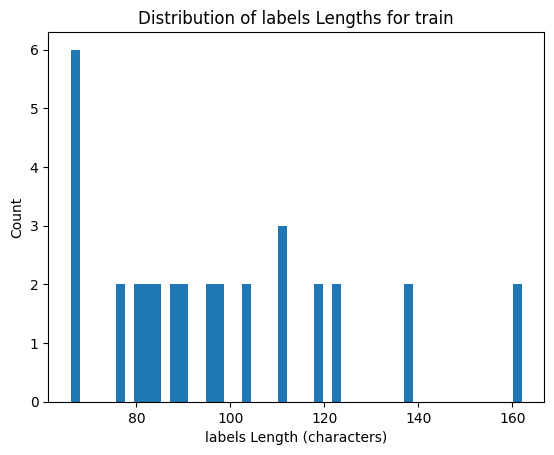

Maximum: 122
Mean: 87.5
Median: 83.5


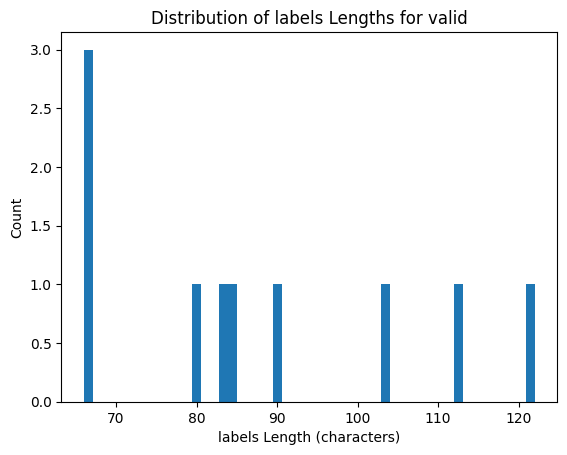

Maximum: 112
Mean: 89.2
Median: 84


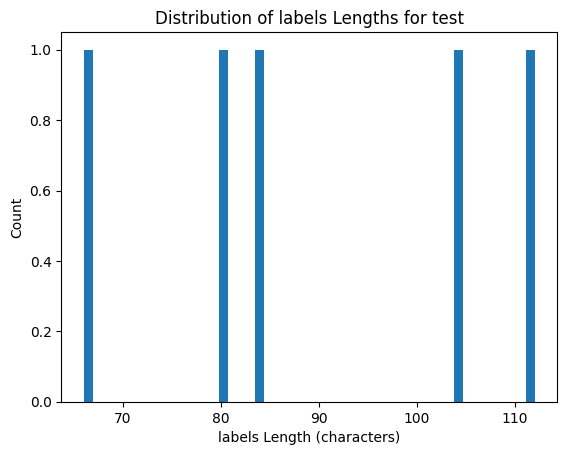

In [10]:
# Call visualize_features() function for training, validation and testing
visualize_features(train_df, 'train', 'hypothesis', 'labels')
visualize_features(valid_df, 'valid', 'hypothesis', 'labels')
visualize_features(test_df, 'test', 'hypothesis', 'labels')

##### Task 5: Create Visualizations Function for Labels

In [11]:
# Write visualize_label() function
def visualize_label(dataset, datatype):
    label_counts = dataset['labels'].value_counts()
    print('label_counts:', label_counts)
    plt.bar(label_counts.index, label_counts.values)
    plt.show()
    


label_counts: labels
Entailment       18
NotMentioned     13
Contradiction     4
Name: count, dtype: int64


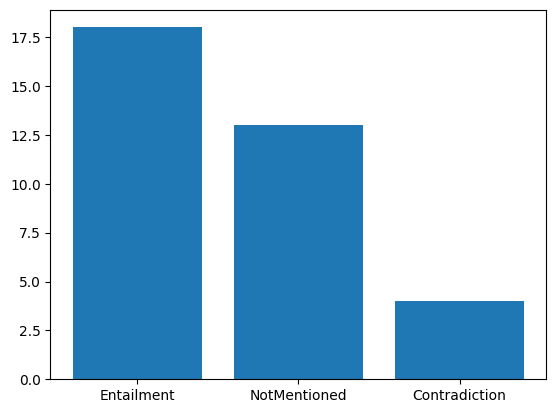

label_counts: labels
Entailment       9
Contradiction    1
Name: count, dtype: int64


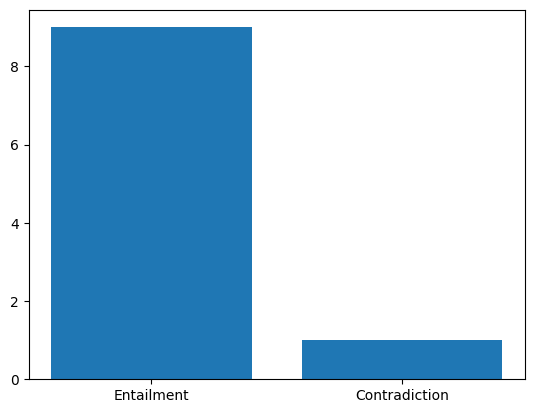

label_counts: labels
Entailment       9
Contradiction    1
Name: count, dtype: int64


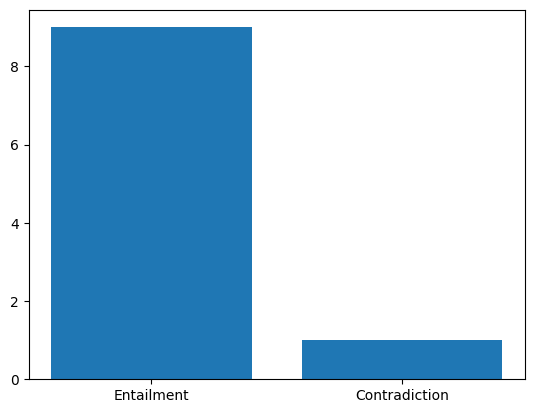

In [12]:
# Call visualize_label() function for training, validation and testing.
visualize_label(train_df, 'train')
visualize_label(valid_df, 'valid')
visualize_label(valid_df, 'test')


##### Task 6: Load the Tokenizer and Model

In [13]:
# ALBERT tokenizer and model
albert_model_name = 'albert-base-v2'
albert_tokenizer = AutoTokenizer.from_pretrained(albert_model_name)
albert_classifier_model = AutoModelForSequenceClassification.from_pretrained(albert_model_name, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# DistilBERT tokenizer and model
distilbert_model_name = 'distilbert-base-uncased'
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)
distilbert_classifier_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Task 7: Encode the Features

In [15]:
# Write tokenize_data() function
def tokenize_data(dataset, model_name):
    if model_name == 'albert':
        return albert_tokenizer(text=dataset['text'].tolist(), text_pair=dataset['hypothesis'].tolist(), padding='max_length', max_length=256, truncation=True)
    else:
        return distilbert_tokenizer(text=dataset['text'].tolist(), text_pair=dataset['hypothesis'].tolist(), padding='max_length', max_length=256, truncation=True)    



In [16]:
# Call tokenize_data() function for training, validation and testing.
## ALBERT model
albert_train_encodings = tokenize_data(train_df, 'albert')
albert_valid_encodings = tokenize_data(valid_df, 'albert')
albert_test_encodings = tokenize_data(test_df, 'albert')
## DistilBERT model
distilbert_train_encodings = tokenize_data(train_df, 'distilbert')
distilbert_valid_encodings = tokenize_data(valid_df, 'distilbert')
distilbert_test_encodings = tokenize_data(test_df, 'distilbert')

##### Task 8: Encode the Label

In [17]:
label_mapping = {'NotMentioned':0, 'Entailment':1, 'Contradiction':2}
train_labels, valid_labels, test_labels = [], [], []
for label in train_df['labels'].to_list():
    train_labels.append(label_mapping[label])
for label in valid_df['labels'].to_list():
    valid_labels.append(label_mapping[label])
for label in test_df['labels'].to_list():
    test_labels.append(label_mapping[label])


##### Task 9: Prepare Dataset for the Model

In [18]:
# Write ContractNLIDataset() class.
class  ContractNLIDataset():
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {}
        for key, value in self.encodings.items():
            item[key] = torch.tensor(value[idx])
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item
            
    
    def __len__(self):
        return len(self.labels)

In [19]:
# Create the objects from ContractNLIDataset() class for training, validation and testing.
## ALBERT model
albert_train_dataset =  ContractNLIDataset(albert_train_encodings, train_labels)
albert_valid_dataset =  ContractNLIDataset(albert_valid_encodings, valid_labels)
albert_test_dataset =  ContractNLIDataset(albert_test_encodings, test_labels)
## DistilBERT model
distilbert_train_dataset =  ContractNLIDataset(distilbert_train_encodings, train_labels)
distilbert_valid_dataset =  ContractNLIDataset(distilbert_valid_encodings, valid_labels)
distilbert_test_dataset =  ContractNLIDataset(distilbert_test_encodings, test_labels)

##### Task 10: Fine-Tune the Selected Models

In [20]:
# Write compute_metrics() function. 
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis = 1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = precision_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [47]:
# configure the training setting
training_args  = TrainingArguments(output_dir='/usercode/results', num_train_epochs=5, weight_decay=0.01, logging_steps=1, evaluation_strategy='epoch')



In [48]:
# Write train_fn() function
def train_fn(model, train_dataset, eval_dataset, tokenizer):
    trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset, tokenizer=tokenizer, compute_metrics= compute_metrics,)
    trainer.train()
    return trainer



In [49]:
# Call train_fn() function
## ALBERT model
albert_trainer = train_fn(albert_classifier_model, albert_train_dataset, albert_valid_dataset, albert_tokenizer)

## DistilBERT model
distilbert_trainer = train_fn(distilbert_classifier_model, distilbert_train_dataset, distilbert_valid_dataset, distilbert_tokenizer)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.877300,1.027673,0.200000,0.333333,0.333333,0.121212
2,0.814500,1.229283,0.000000,0.000000,0.000000,0.000000
3,0.922700,1.149028,0.000000,0.000000,0.000000,0.000000
4,0.990300,1.116729,0.000000,0.000000,0.000000,0.000000
5,1.209800,1.097945,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Pr

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.754700,0.878124,0.900000,0.450000,0.450000,0.473684
2,0.872600,0.812076,0.900000,0.450000,0.450000,0.473684
3,0.872400,0.780005,0.900000,0.450000,0.450000,0.473684
4,1.044600,0.799551,0.900000,0.450000,0.450000,0.473684
5,1.246200,0.811160,0.900000,0.450000,0.450000,0.473684


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Pr

##### Task 11: Test the Selected Models

In [50]:
# Write predict_and_save_results() function
def predict_and_save_results(trainer, model, model_name, test_dataset):
    prediction_output = trainer.predict(test_dataset)
    prediction_output = np.argmax(prediction_output[0], axis = 1)
    test_df['pred_from_%s'%model_name] = prediction_output

In [51]:
# Call predict_and_save_results() function.
## ALBERT model
predict_and_save_results(albert_trainer, albert_classifier_model, 'albert_model_name', albert_test_dataset)
## DistilBERT model
predict_and_save_results(distilbert_trainer, distilbert_classifier_model, 'distilbert_model_name', distilbert_test_dataset)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Task 12: Identify Incorrect Predictions

In [52]:
albert_col_name = 'pred_from_albert_model_name'
distilbert_col_name = 'pred_from_distilbert_model_name'

# For the ALBERT model
print(test_df[albert_col_name] == test_labels)
# For the DistilBERT model 
print(test_df[distilbert_col_name] == test_labels)

0    False
1     True
2     True
3    False
4    False
Name: pred_from_albert_model_name, dtype: bool
0    False
1     True
2     True
3    False
4    False
Name: pred_from_distilbert_model_name, dtype: bool


##### Task 13: Categorize the Errors

In [53]:
## ALBERT model
albert_misclass = test_df[test_df[albert_col_name]!= test_labels].iloc[:,:3]
print(albert_misclass)
# For the DistilBERT model
distilbert_misclass = test_df[test_df[distilbert_col_name]!= test_labels].iloc[:,:3]
print(distilbert_misclass)

                                                text  \
0  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
3  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
4  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   

                                          hypothesis         labels  
0  Receiving Party shall not reverse engineer any...   NotMentioned  
3  Receiving Party shall not disclose the fact th...   NotMentioned  
4  Confidential Information shall only include te...  Contradiction  
                                                text  \
0  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
3  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
4  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   

                                          hypothesis         labels  
0  Receiving Party shall not reverse engineer any...   NotMentioned  
3  Receiving Party shall not disclose the fact th...   NotMentioned  
4  Confidential Information shall only include te...  Contra

##### Task 14: Visualize Error Categories

label_counts: labels
NotMentioned     2
Contradiction    1
Name: count, dtype: int64


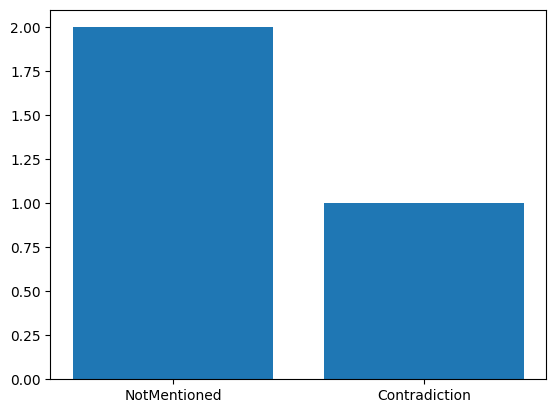

Maximum: 16632
Mean: 16632
Median: 16632


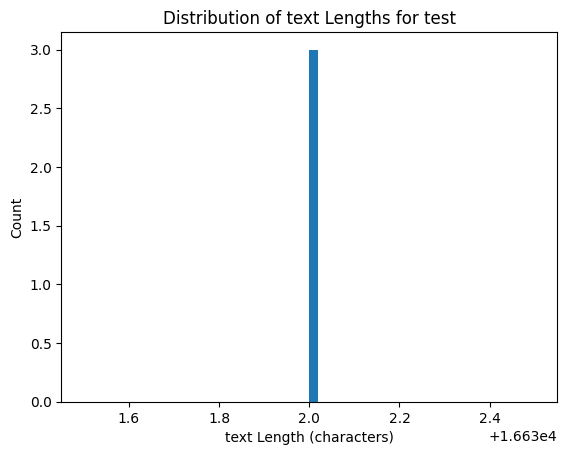

Maximum: 112
Mean: 87.33333333333333
Median: 84


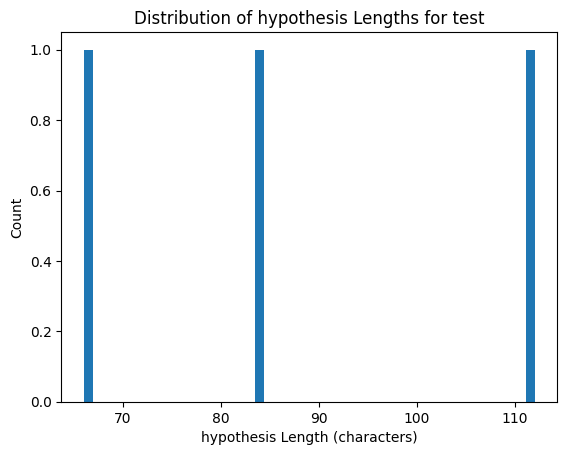

In [54]:
## ALBERT model
visualize_label(albert_misclass, 'test')
visualize_features(albert_misclass, 'test', 'text', 'text')
visualize_features(albert_misclass, 'test', 'hypothesis', 'hypothesis')

label_counts: labels
NotMentioned     2
Contradiction    1
Name: count, dtype: int64


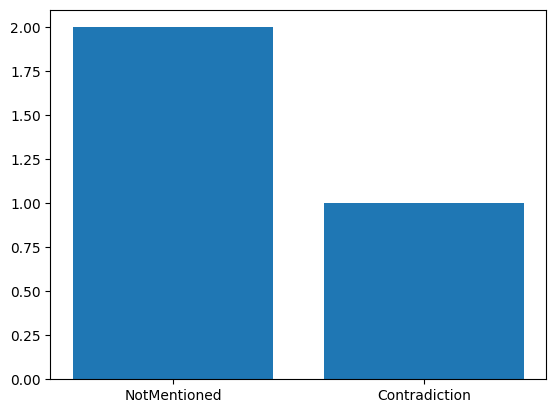

Maximum: 16632
Mean: 16632
Median: 16632


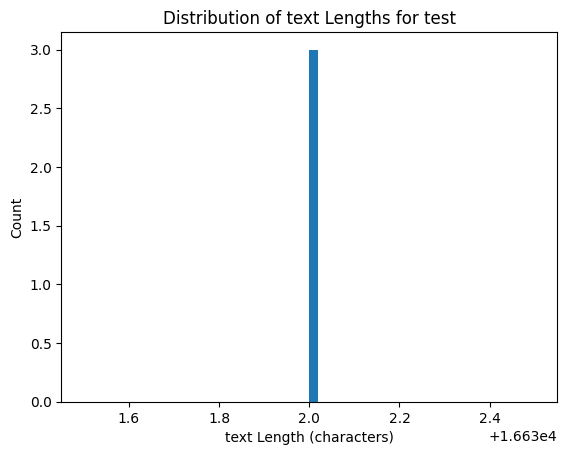

Maximum: 112
Mean: 87.33333333333333
Median: 84


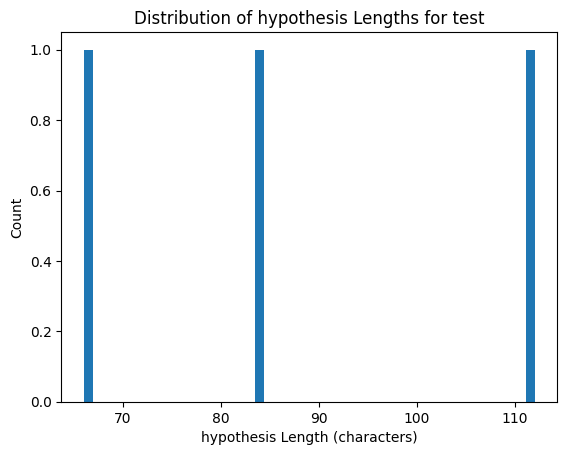

In [55]:
## DistilBERT model
visualize_label(distilbert_misclass, 'test')
visualize_features(distilbert_misclass, 'test', 'text', 'text')
visualize_features(distilbert_misclass, 'test', 'hypothesis', 'hypothesis')